# Wind Turbine Object Detection from Aerial Imagery Using TensorFlow Object Detection API and Google Colab

## Introduction

This notebook provides the full pipeline to perform training and inference for a wind turbine object detection model using publically available aerial images and the [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). It is designed to run in [Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb), a Jupyter notebook environment running on a virtual machine (VM) that provides free access to a Tesla K80 GPU for up to 12 hours.


The aerial image data set used in this notebook is obtained from the [National Agriculture Imagery Program (NAIP) database](https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-programs/naip-imagery/) using [USGS EarthExplorer](https://earthexplorer.usgs.gov/). The particular NAIP images used to train, test, and validate this model are from three wind farms located in west-central Iowa containing turbines of varying capacity, style, and manufacturer. A sample NAIP image is presented below in the "Sample NAIP image" section. The original NAIP images are 5978 x 7648 so they had to be chopped into smaller individual images to avoid excessive memory use. In addition, the ratio of object size to image size is improved by this operation. An image size of 300 x 300 was chosen since the TensorFlow object detection SSD-based models rescale all input images to this size. 

A total of 488 images, all containing at least one full wind turbine, were collected and split into train (\~80%), test (\~16%), and validate (\~4%) sets. [LabelImg](https://github.com/tzutalin/labelImg) was then used to label all the images in the train and test sets. Samples of the chopped and annotated images are shown below in the "Sample chopped and annotated NAIP images" section. Annotating the images in LabelImg creates an XML file corresponding to each image. These XML files must be converted to CSV and then TFRecords. Sample code for this can be found [here](https://towardsdatascience.com/how-to-train-your-own-object-detector-with-tensorflows-object-detector-api-bec72ecfe1d9) or [here](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html) (among other places).

In [1]:
# clone wind-turbine-detector repo
!git clone https://github.com/lbborkowski/wind-turbine-detector.git

Cloning into 'wind-turbine-detector'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (596/596), done.
remote: Compressing objects: 100% (583/583), done.
remote: Total 596 (delta 38), reused 541 (delta 10), pack-reused 0
Receiving objects: 100% (596/596), 211.10 MiB | 8.34 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Checking out files: 100% (523/523), done.


### Sample NAIP image

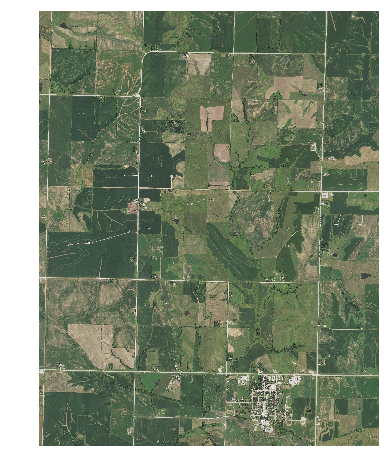

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import os
import glob

%matplotlib inline

image = Image.open('/content/wind-turbine-detector/images/samples/orig/m_4109442_se_15_1_20170709.jpg')
plt.figure(figsize=(12,8))
plt.axis('off')
plt.imshow(image)

### Sample chopped and annotated NAIP images

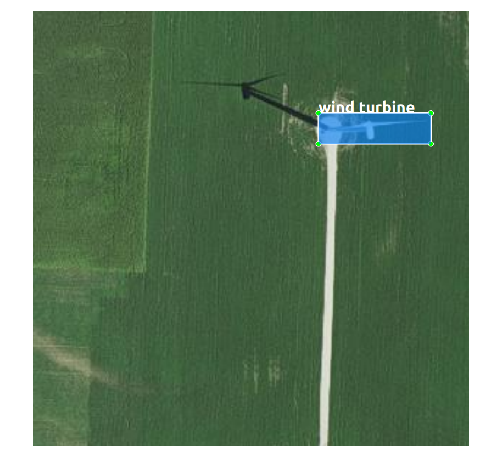

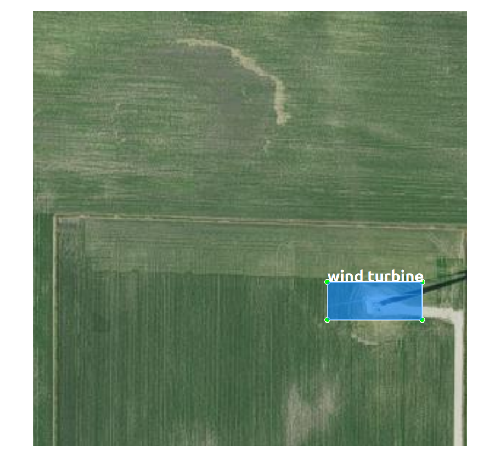

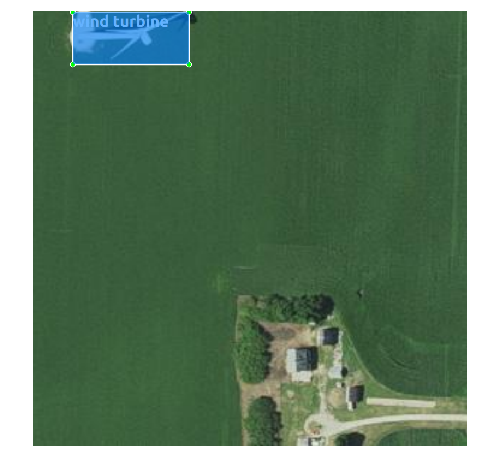

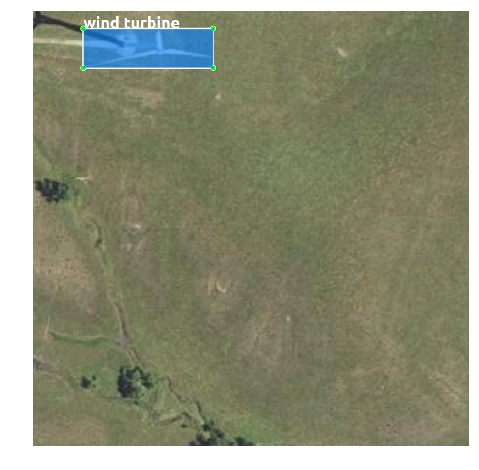

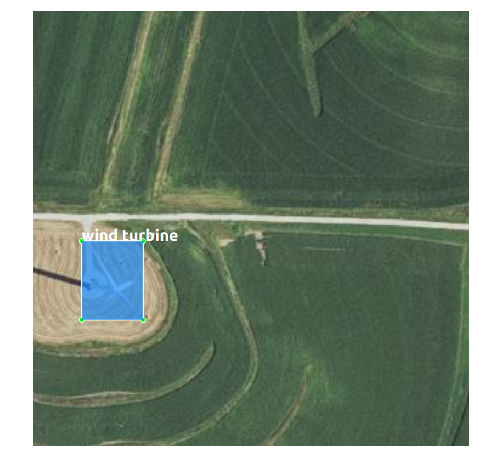

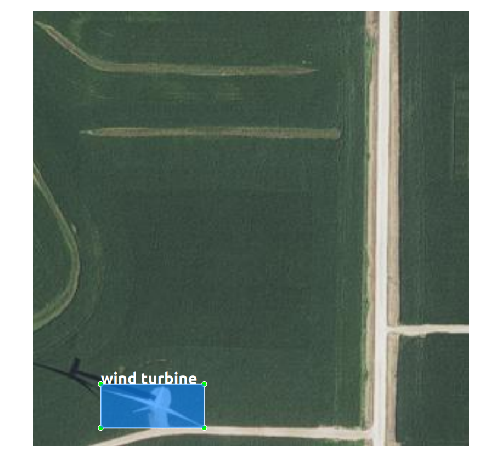

In [3]:
PATH_TO_SAMPLE_IMAGES_DIR = '/content/wind-turbine-detector/images/samples/chopped'
SAMPLE_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_SAMPLE_IMAGES_DIR, "*.*"))

for image_path in SAMPLE_IMAGE_PATHS:
  image = Image.open(image_path)
  plt.figure(figsize=(12,8))
  plt.axis('off')
  plt.imshow(image)

## Training
Training will be performed on the 392 labeled images in the train image set and tested against the 80 labeled test images. A pre-trained model from the [TensorFlow Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) is used as a starting point. In this notebook, the ssd_inception_v2_coco model is used based on its balance of accuracy and efficiency.  


> *Note: If you wish to skip the training step, you can uncomment the second "PATH_TO_FROZEN_GRAPH=" line in the **Inference** section to use the provided pre-trained wind turbine detection model.  Training will take ~2.5 hours.*



### Install all required libraries
Further details on how to install and configure TensorFlow Object Detection API can be found [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md).

In [4]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install contextlib2
!pip install jupyter
!pip install matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-tk is already the newest version (2.7.15~rc1-1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 8 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,688 kB of additional disk space will be used.
Get:1 http:/

### Clone TensorFlow Object Detection API repo

In [0]:
!git clone --quiet https://github.com/tensorflow/models.git

### COCO API installation
This is needed if you are interested in using COCO evaluation metrics.

In [6]:
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/models/research/

Cloning into 'cocoapi'...
remote: Enumerating objects: 953, done.
remote: Total 953 (delta 0), reused 0 (delta 0), pack-reused 953
Receiving objects: 100% (953/953), 11.70 MiB | 1.20 MiB/s, done.
Resolving deltas: 100% (565/565), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python2.7/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-2.7
creating build/temp.linux-x86_64-2.7/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -fno-strict-aliasing -Wdate-time -D_FORTIFY_SOURCE=2 -g -fdebug-prefix-map=/build/python2.7-3hk45v/python2.7-2.7.15~rc1=

### Protobuf compilation
The Protobuf libraries provided in the TensorFlow Object Detection API repo must be compiled in order to use the framework.

In [7]:
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/models/research


### Add Libraries to PYTHONPATH

In [8]:
%set_env PYTHONPATH=$PYTHONPATH:/content/models/research:/content/models/research/slim

env: PYTHONPATH=$PYTHONPATH:/content/models/research:/content/models/research/slim


### Test the installation

In [9]:
!python object_detection/builders/model_builder_test.py

W0618 17:27:57.516705 140036806432640 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0618 17:27:57.814224 140036806432640 deprecation_wrapper.py:119] From /content/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0618 17:27:57.862209 140036806432640 deprecation_wrapper.py:119] From /content/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

Running tests under Python 2.7.15: /usr/bin/python2
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       O

### Setup and run TensorBoard
TensorBoard provides a visualization of various quantitative metrics such as loss as well as a comparison between prediction vs. groundtruth for a subset of images.

In [0]:
%cd /content/wind-turbine-detector

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = 'training/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

#### Get Tensorboard link
Click on the link to launch Tensorboard. It will update once the first checkpoint is saved. The plot of the "loss_1" scalar will provide the loss as a function of step, matching what is printed to the screen.

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

### Train model
Train the wind turbine detector model using a modified model_main.py file which includes "tf.logging.set_verbosity(tf.logging.INFO)" following the import statements to output the loss every 100 steps. The model configuration is provided in wind-turbine-detector/training/ssd_inception_v2_coco_WTDetector.config. This configuration file uses all the default settings provided in the sample ssd_inception_v2_coco.config file except the following:

*   num_classes: 1
*   batch_size: 12
*   fine_tune_checkpoint: "pre-trained-model/model.ckpt"
*   train_input_reader: {
  tf_record_input_reader {
    input_path: "annotations/train.record"
  }
  label_map_path: "annotations/label_map.pbtxt"
}
    * *Note: The 'label_map.pbtxt' file required for training contains 1 class: item {
id: 1
name: 'wind turbine'
}*
*   eval_input_reader: {
  tf_record_input_reader {
    input_path: "annotations/test.record"
  }
  label_map_path: "annotations/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}  



Additional data (image) augmentation was prescribed in the configuration file. Combining a vertical flip and a 90 degree rotation with the default horizontal flip, the training data can be extended to contain all possible wind turbine orientations. These operations help to generalize the model.
*   data_augmentation_options {
    random_vertical_flip {
    }
  }
*   data_augmentation_options {
    random_rotation90 {
    }
  }










In [0]:
!python model_main.py --pipeline_config_path=training/ssd_inception_v2_coco_WTDetector.config --model_dir=training/ --num_train_steps=20000 --alsologtostderr
#!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/ssd_inception_v2_coco_WTDetector.config # using legacy training code

### Export trained wind turbine detector model

In [0]:
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=training/ssd_inception_v2_coco_WTDetector.config \
    --output_directory=WTDetectorModel \
    --trained_checkpoint_prefix=training/model.ckpt-20000

## *Inference*

Perform inference using the newly trained wind turbine detection model on the validation image set. This set of images was kept separate from the test and train image sets and will now be used to validate the accuracy of the model.   

In [10]:
%cd /content/models/research/object_detection

/content/models/research/object_detection


### Imports

In [11]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

ValueError: ignored

#### Env setup

In [0]:
# This is needed to display the images.
%matplotlib inline

#### Object detection imports
Here are the imports from the object detection module.

In [13]:
from utils import label_map_util

from utils import visualization_utils as vis_util

utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.p

### Model preparation 

#### Variables

Any model exported using the "export_inference_graph.py" tool can be loaded here simply by changing "PATH_TO_FROZEN_GRAPH" to point to a new .pb file.  

In [0]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
#PATH_TO_FROZEN_GRAPH = '/content/wind-turbine-detector/WTDetectorModel/frozen_inference_graph.pb'
PATH_TO_FROZEN_GRAPH = '/content/wind-turbine-detector/trainedWTDetector/frozen_inference_graph.pb' # Uncomment this line to run inference (without training) using provided pre-trained model

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/wind-turbine-detector/annotations/label_map.pbtxt'

#### Load a (frozen) TensorFlow model into memory

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

#### Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to "airplane".  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

W0618 17:33:17.452681 140714643908480 deprecation_wrapper.py:119] From utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



{1: {'id': 1, 'name': u'wind turbine'}}


#### Helper code

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

### Detection

In [18]:
import os
import glob

PATH_TO_TEST_IMAGES_DIR = '/content/wind-turbine-detector/images/samples/orig'
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
print(TEST_IMAGE_PATHS)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['/content/wind-turbine-detector/images/samples/orig/m_4109442_se_15_1_20170709.jpg']


In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

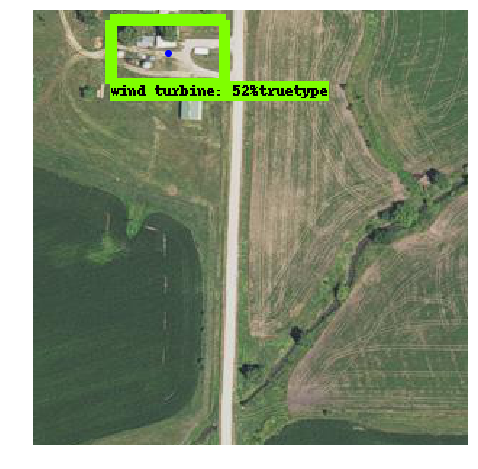

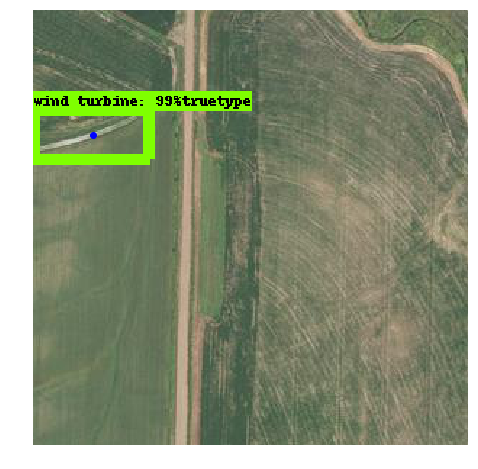

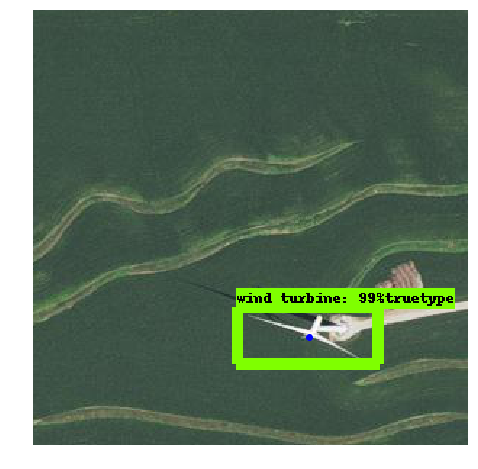

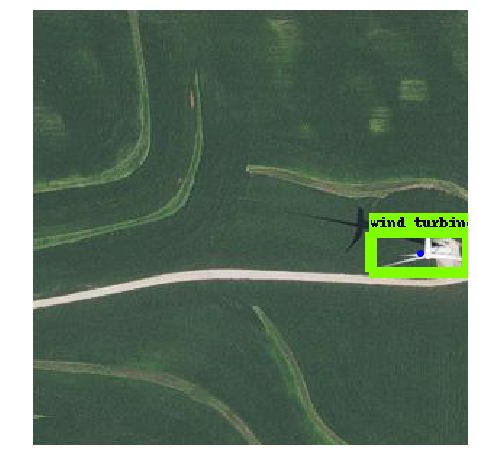

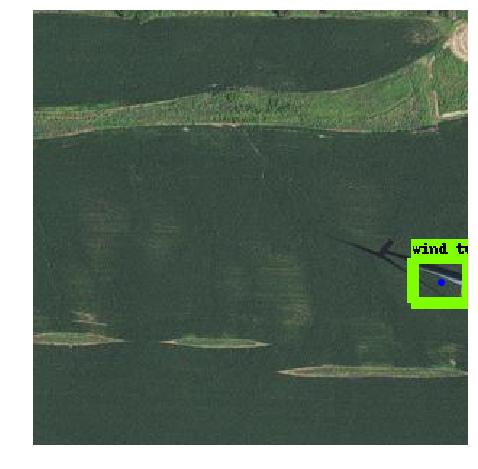

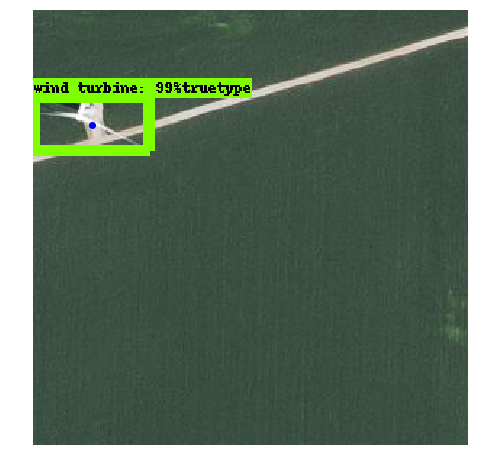

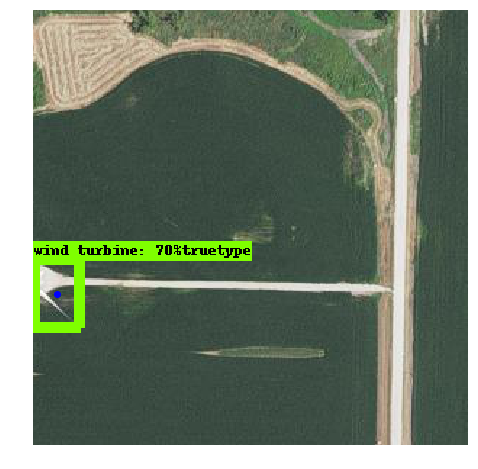

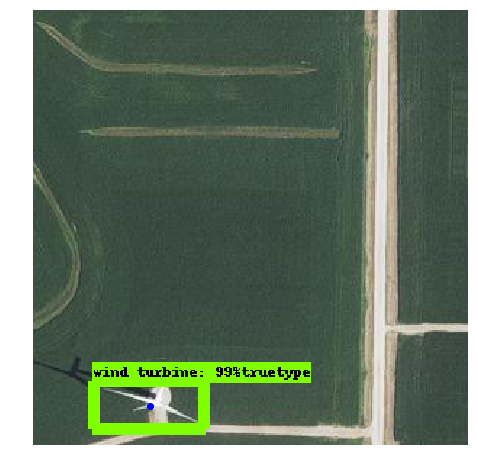

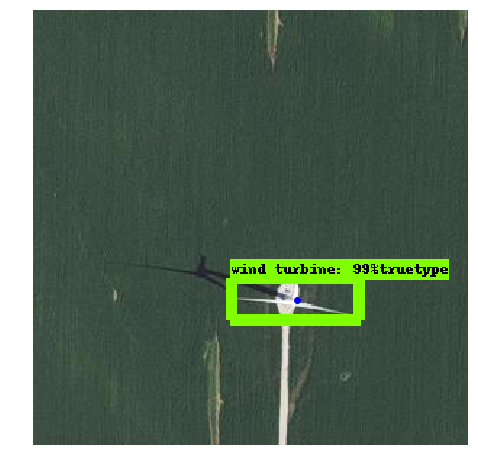

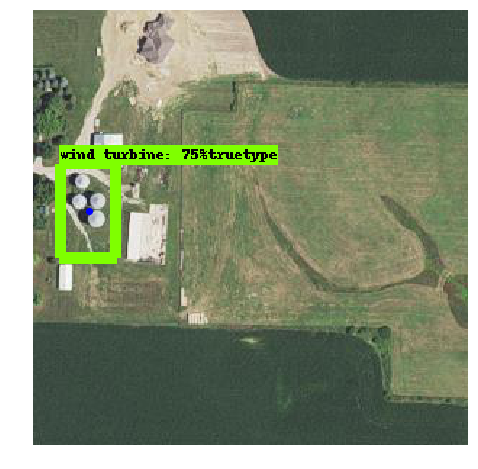

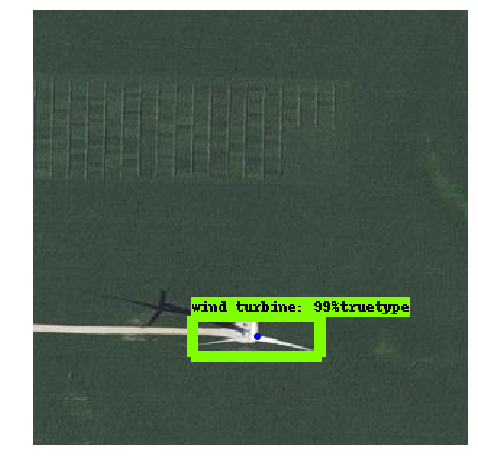

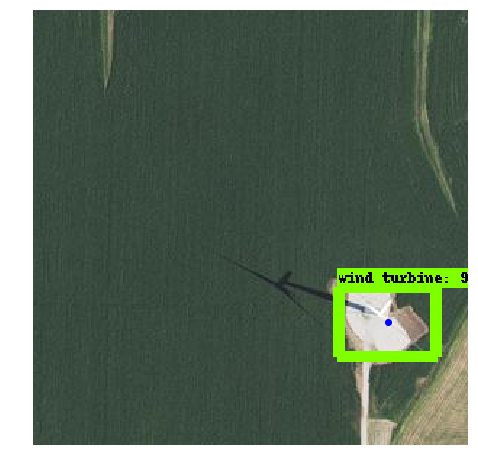

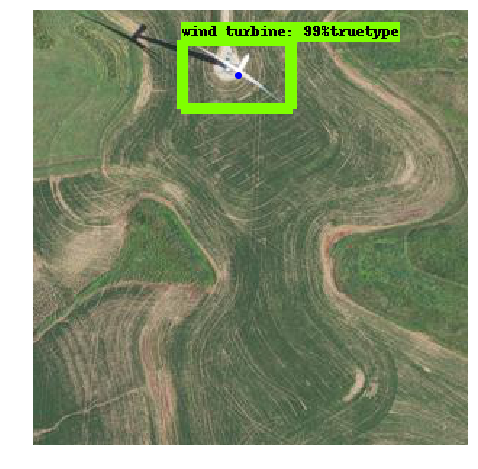

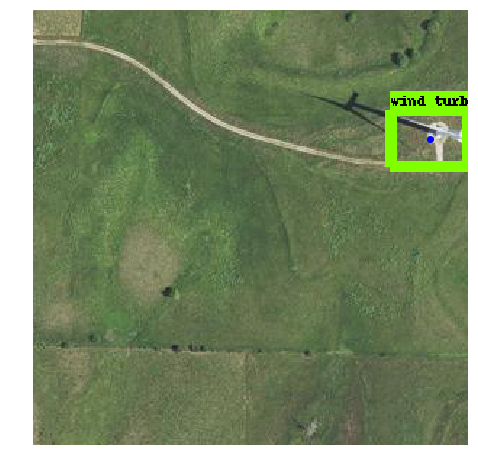

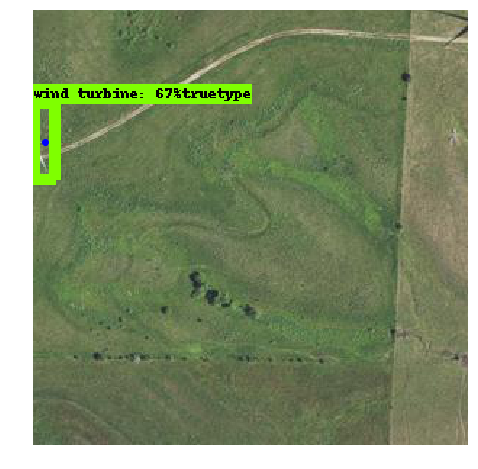

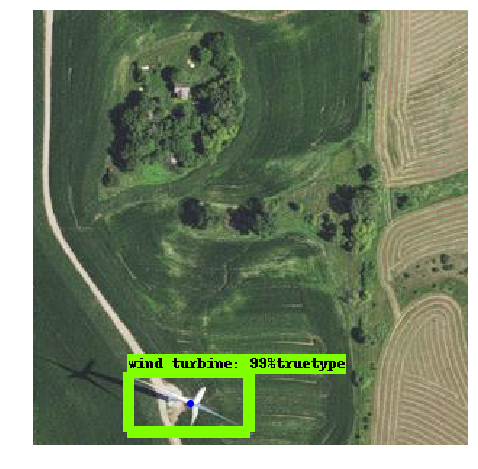

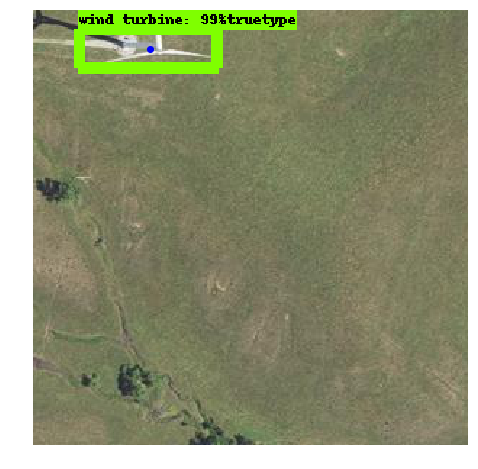

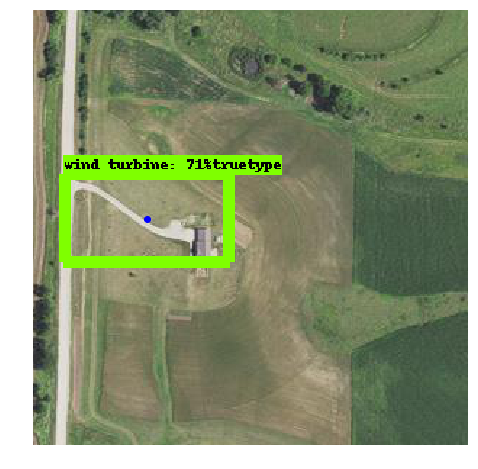

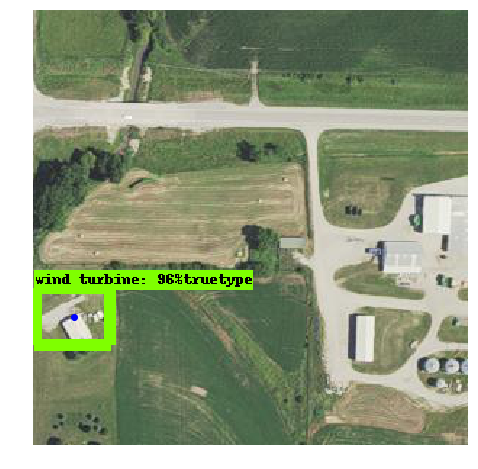

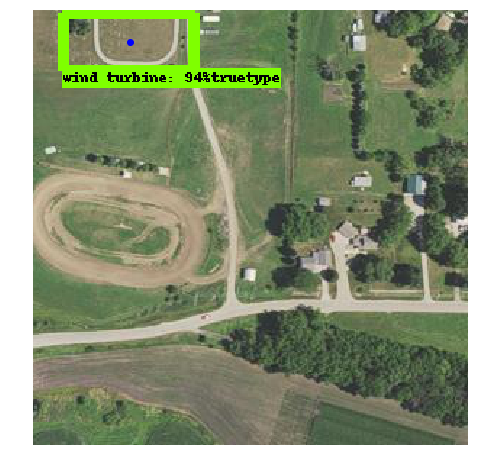

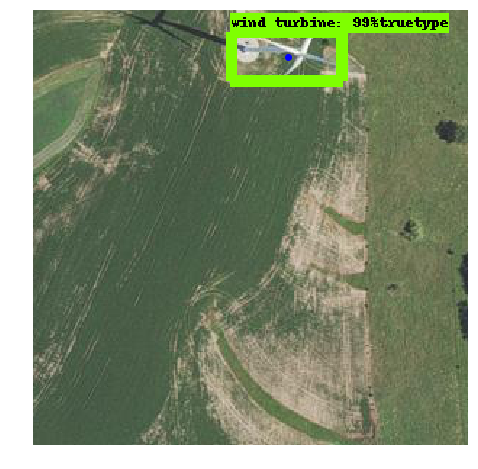

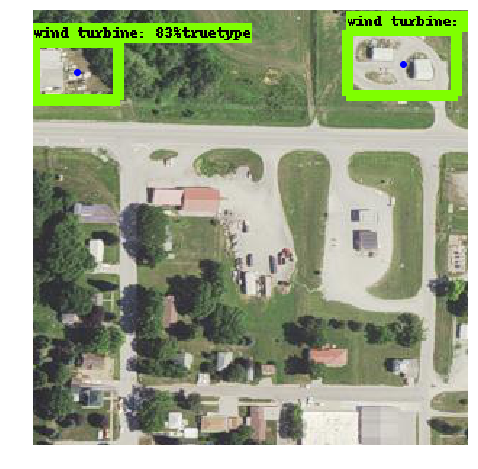

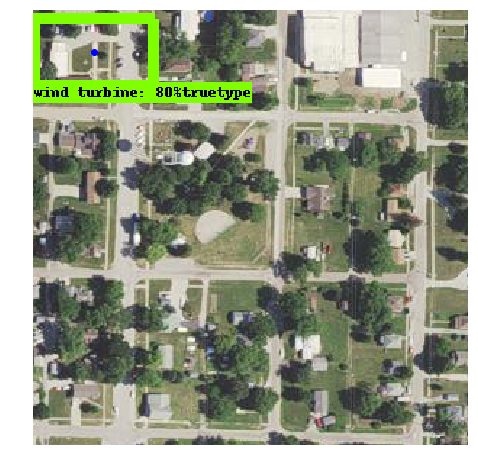

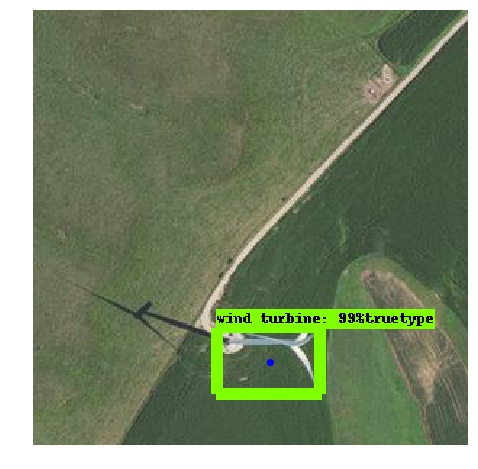

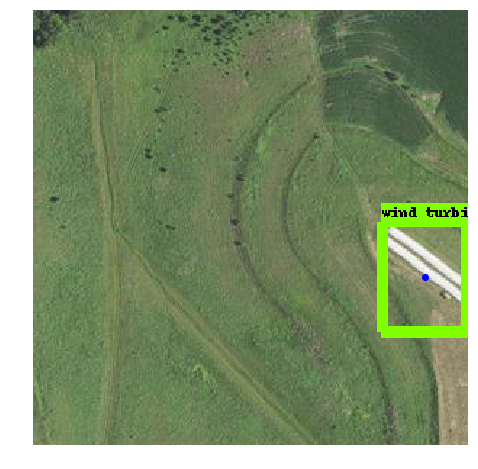

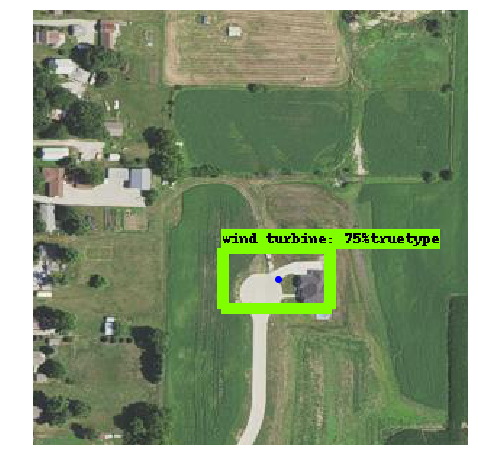

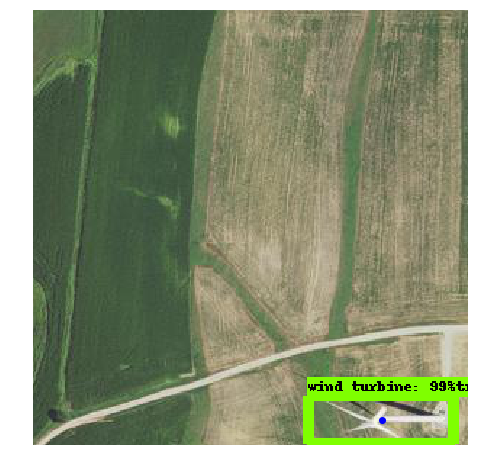

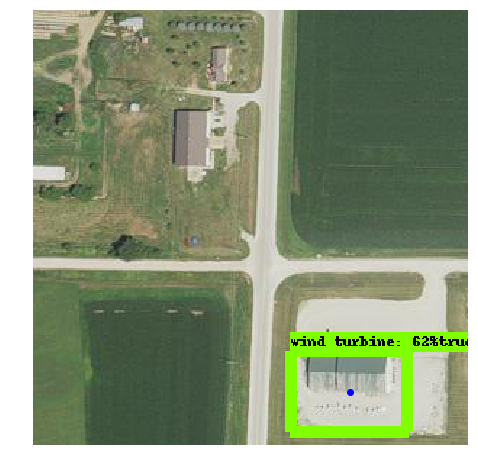

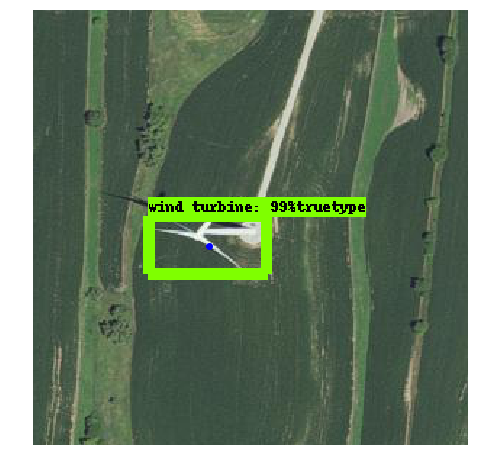

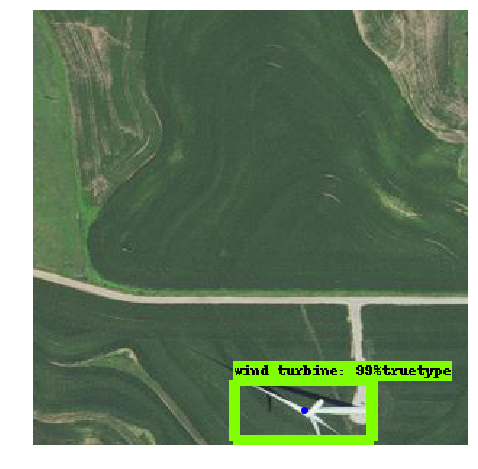

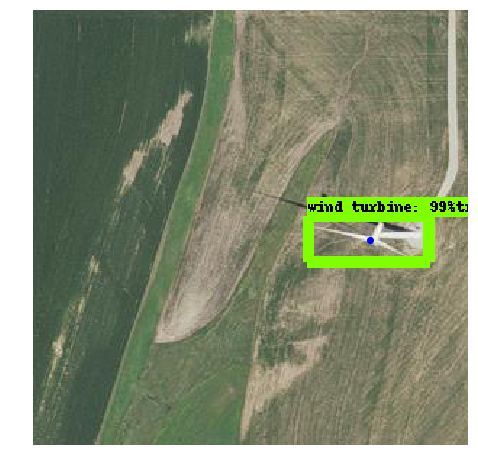

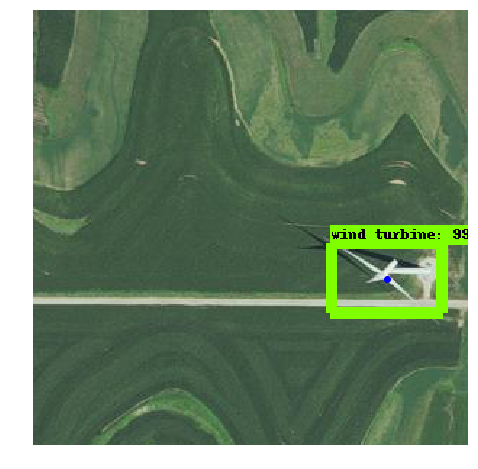

In [45]:
scoresWTs = np.array([])
BBsWTs = np.empty((0, 4))
chipsize = 300
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  width, height = image.size
  for x0 in range(0, width, chipsize):
    for y0 in range(0, height, chipsize):
      box = (x0, y0,
             x0+chipsize,
             y0+chipsize)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image.crop(box))
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      output_dict = run_inference_for_single_image(image_np, detection_graph)
      scoresWTs=np.append(scoresWTs,output_dict['detection_scores'][output_dict['detection_scores']>0.5],axis=0)
      BBsWTs=np.append(BBsWTs,output_dict['detection_boxes'][output_dict['detection_scores']>0.5],axis=0)
      if len(output_dict['detection_scores'][output_dict['detection_scores']>0.5])>0:
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.axis('off')
        for jj in range(len(output_dict['detection_scores'][output_dict['detection_scores']>0.5])):
          plt.plot(chipsize*np.mean([BBsWTs[-1-jj][1],BBsWTs[-1-jj][3]]),chipsize*np.mean([[BBsWTs[-1-jj][0],BBsWTs[-1-jj][2]]]),'bo')
        plt.imshow(image_np)
      

In [46]:
print(scoresWTs)
print(len(scoresWTs))
print(BBsWTs)
print(len(BBsWTs))

[0.52498269 0.99393803 0.99999988 0.98494512 0.65889621 0.99841309
 0.70919061 0.99996674 0.99884772 0.75398469 0.99965888 0.99999535
 0.99998868 0.99065894 0.67141199 0.99999595 0.99916732 0.71332777
 0.96523583 0.9438563  0.99062425 0.97085118 0.83081132 0.80199456
 0.99999833 0.98701882 0.75986719 0.99778074 0.62617832 0.9999997
 0.9999997  0.99916542 0.99999219]
33
[[0.0245911  0.17673849 0.16828606 0.44210678]
 [0.23193264 0.         0.34027416 0.26978707]
 [0.68649769 0.46926391 0.81324363 0.79373801]
 [0.51103574 0.77457356 0.60186058 1.        ]
 [0.57273483 0.87141275 0.67324531 1.        ]
 [0.20251432 0.         0.32294694 0.26907355]
 [0.57562786 0.         0.7282874  0.10811069]
 [0.85402775 0.13810143 0.96290648 0.39577481]
 [0.61829358 0.4557012  0.71114796 0.75253415]
 [0.35401186 0.06217489 0.56934237 0.19120514]
 [0.70338964 0.3655476  0.79402304 0.66083843]
 [0.63765562 0.70147067 0.79575264 0.92824775]
 [0.07051625 0.34304819 0.22585905 0.59417748]
 [0.23100019 0.82

In [47]:
(len(BBsWTs),2)

(33, 2)

In [48]:
centerBBs = np.empty((len(BBsWTs),2))
print(centerBBs)
ii=0
for BBs in BBsWTs:
  print(BBs)
  centerBBs[ii][:]=[np.mean([BBs[1],BBs[3]]),np.mean([[BBs[0],BBs[2]]])]
  ii+=1

print(centerBBs)
print(centerBBs.shape)

[[4.66542999e-310 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.12199579e-314]
 [2.12199579e-314 2.

## Summary

The trained model accurately detects 15 out of 17 wind turbines in the validation image set with high probability. This represents an accuracy of ~90% (88.2%). Higher accuracy would likely be acheived by using a larger set of images (train + test) as well as using a more accurate pre-trained model. Alternative models, including those with higher mAP, can be found at the [TensorFlow Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). Details of the trade-offs between speed, accuracy, and memory for various object detection model architectures (Faster RCNN, SSD, R-FCN) can be found in this [paper](https://arxiv.org/pdf/1611.10012.pdf), which can serve as a good starting point in determining which architecture is best for your application.